In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import itertools

import scipy.stats as stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest,RFE,f_regression

%matplotlib inline

### Import the dataset

In [670]:
sales = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\2. Walmart Store Sales Forecasting\\data\\stores.csv')
sales.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [671]:
features = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\2. Walmart Store Sales Forecasting\\data\\features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [672]:
train = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\2. Walmart Store Sales Forecasting\\data\\train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Join the tables to obtain all the features into one dataframe.

In [674]:
data = features.merge(how='inner',on='Store',right=sales)
data = train.merge(on=['Store','Date'],right=data, how='left')
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [675]:
data.Date = pd.to_datetime(data.Date)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday_x     421570 non-null bool
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
IsHoliday_y     421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 52.3+ MB


Drop 'IsHoliday_y' as it is duplicate.

In [676]:
data.drop(columns=['IsHoliday_y'], inplace=True)

In [677]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


### Missing Value Treatment

In [679]:
def MissingTreatment(x):
    x = x.fillna(0)
    return x
data = data.apply(lambda x: MissingTreatment(x))
data.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday_x     421570 non-null bool
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
Type            421570 non-null object
Size            421570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 51.9+ MB


In [689]:
numeric_vars = [key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
numeric_vars.remove('Store')
numeric_vars.remove('Dept')
print(numeric_vars)

['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']


### Outlier Treatment

In [125]:
def OutlierRemover(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x
data[numeric_vars] = data[numeric_vars].apply(lambda x: OutlierRemover(x))

Correlation metrics

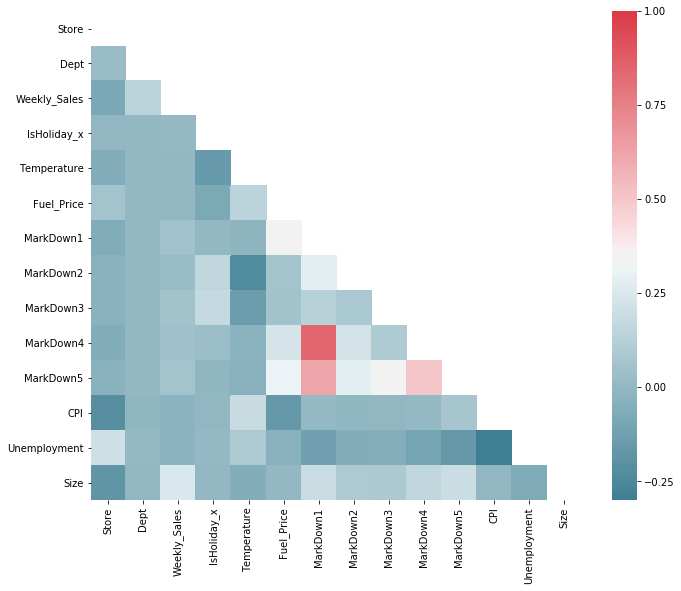

In [126]:
corr = data.corr()


mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap)
plt.show()

### Feature Engineering

In [745]:
data['Month'] = data.Date.apply(lambda x: datetime.strftime(x,format="%m"))
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,02
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,02
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,02
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,02
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,03


In [746]:
data['Year'] = data.Date.apply(lambda x: datetime.strftime(x,format="%Y"))
data['Week'] = data.Date.apply(lambda x: datetime.strftime(x,format="%W"))
data['Quarter'] = data.Date.apply(lambda x: (int(datetime.strftime(x,format="%m")) - 1) // 3 + 1)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Year,Week,Quarter
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,02,2010,05,1
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,02,2010,06,1
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,02,2010,07,1
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,02,2010,08,1
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,03,2010,09,1


In [747]:
max_df = data.groupby(['Store','Dept'])['Weekly_Sales'].max()
min_df = data.groupby(['Store','Dept'])['Weekly_Sales'].min()
avg_df = data.groupby(['Store','Dept'])['Weekly_Sales'].mean()
med_df = data.groupby(['Store','Dept'])['Weekly_Sales'].median()
std_df = data.groupby(['Store','Dept'])['Weekly_Sales'].std()

In [748]:
def FeatureEngineering(store,dept,var):
    if var == 'max':
        return max_df.loc[store,dept]
    elif var == 'min':
        return min_df.loc[store,dept]
    elif var == 'avg':
        return avg_df.loc[store,dept]
    elif var == 'median':
        return med_df.loc[store,dept]
    elif var == 'std':
        return std_df.loc[store,dept]
    else:
        print(store,dept)
        return -1

data['Max_WeeklySales_by_Store_Dept'] = data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'max'), axis=1)
data['Min_WeeklySales_by_Store_Dept'] = data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'min'), axis=1)
data['Avg_WeeklySales_by_Store_Dept'] = data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'avg'), axis=1)
data['Median_WeeklySales_by_Store_Dept'] = data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'median'), axis=1)
data['Std_WeeklySales_by_Store_Dept'] = data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'std'), axis=1)

In [749]:
data

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size,Month,Year,Week,Quarter,Max_WeeklySales_by_Store_Dept,Min_WeeklySales_by_Store_Dept,Avg_WeeklySales_by_Store_Dept,Median_WeeklySales_by_Store_Dept,Std_WeeklySales_by_Store_Dept
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,...,151315,02,2010,05,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,...,151315,02,2010,06,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,...,151315,02,2010,07,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,...,151315,02,2010,08,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,...,151315,03,2010,09,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
5,1,1,2010-03-12,21043.39,False,57.79,2.667,0.00,0.00,0.00,...,151315,03,2010,10,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
6,1,1,2010-03-19,22136.64,False,54.58,2.720,0.00,0.00,0.00,...,151315,03,2010,11,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
7,1,1,2010-03-26,26229.21,False,51.45,2.732,0.00,0.00,0.00,...,151315,03,2010,12,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
8,1,1,2010-04-02,57258.43,False,62.27,2.719,0.00,0.00,0.00,...,151315,04,2010,13,2,57592.12,14537.37,22513.322937,18535.48,9854.349032
9,1,1,2010-04-09,42960.91,False,65.86,2.770,0.00,0.00,0.00,...,151315,04,2010,14,2,57592.12,14537.37,22513.322937,18535.48,9854.349032


In [134]:
data[data['IsHoliday_x'] == True]

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size,Month,Year,Week,Quarter,Max_WeeklySales_by_Store_Dept,Min_WeeklySales_by_Store_Dept,Avg_WeeklySales_by_Store_Dept,Median_WeeklySales_by_Store_Dept,Std_WeeklySales_by_Store_Dept
1,1.0,1.0,2010-02-12,46039.49,True,38.51,2.565,0.00,0.00,0.00,...,151315.0,02,2010,06,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
31,1.0,1.0,2010-09-10,18194.74,True,78.69,2.565,0.00,0.00,0.00,...,151315.0,09,2010,36,3,57592.12,14537.37,22513.322937,18535.48,9854.349032
42,1.0,1.0,2010-11-26,18820.29,True,64.52,2.735,0.00,0.00,0.00,...,151315.0,11,2010,47,4,57592.12,14537.37,22513.322937,18535.48,9854.349032
47,1.0,1.0,2010-12-31,19124.58,True,48.43,2.943,0.00,0.00,0.00,...,151315.0,12,2010,52,4,57592.12,14537.37,22513.322937,18535.48,9854.349032
53,1.0,1.0,2011-02-11,37887.17,True,36.39,3.022,0.00,0.00,0.00,...,151315.0,02,2011,06,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
83,1.0,1.0,2011-09-09,17746.68,True,76.00,3.546,0.00,0.00,0.00,...,151315.0,09,2011,36,3,57592.12,14537.37,22513.322937,18535.48,9854.349032
94,1.0,1.0,2011-11-25,20911.25,True,60.14,3.236,410.31,98.00,2083.28,...,151315.0,11,2011,47,4,57592.12,14537.37,22513.322937,18535.48,9854.349032
99,1.0,1.0,2011-12-30,23350.88,True,44.55,3.129,5762.10,21813.16,260.36,...,151315.0,12,2011,52,4,57592.12,14537.37,22513.322937,18535.48,9854.349032
105,1.0,1.0,2012-02-10,36988.49,True,48.02,3.409,13925.06,6927.23,101.64,...,151315.0,02,2012,06,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
135,1.0,1.0,2012-09-07,18322.37,True,83.96,3.730,5204.68,35.74,50.94,...,151315.0,09,2012,36,3,57592.12,14537.37,22513.322937,18535.48,9854.349032


In [135]:
data['Super Bowl'] = np.where((data.Date == datetime(2010,2,12)) | (data.Date == datetime(2011,2,11)) | (data.Date == datetime(2012,2,10)) | (data.Date == datetime(2013,2,8)),'yes','no')
data['Labor Day'] = np.where((data.Date == datetime(2010,9,10)) | (data.Date == datetime(2011,9,9)) | (data.Date == datetime(2012,9,7)) | (data.Date == datetime(2013,9,6)),'yes','no')
data['Thanksgiving'] = np.where((data.Date == datetime(2010,11,26)) | (data.Date == datetime(2011,11,25)) | (data.Date == datetime(2012,11,23)) | (data.Date == datetime(2013,11,29)),'yes','no')
data['Christmas'] = np.where((data.Date == datetime(2010,12,31)) | (data.Date == datetime(2011,12,30)) | (data.Date == datetime(2012,12,28)) | (data.Date == datetime(2013,12,27)),'yes','no')

In [136]:
cat_vars = ['Store',
            'Dept',
            'Type',
            'IsHoliday_x',
            'Month',
            'Year',
            'Week',
            'Quarter',
            'Super Bowl',
            'Labor Day',
            'Thanksgiving',
            'Christmas'
           ]

### Dummy Variable Creation

In [137]:
def createDummyVariables(df,col):
    df_dummy = pd.get_dummies(data=df[col],drop_first=True,prefix=col)
    df = pd.concat([df,df_dummy],axis=1)
    df.drop(col,axis=1,inplace=True)
    return df

In [138]:
data_cat = data[cat_vars]
for feature in cat_vars:
    data_cat = createDummyVariables(data_cat,feature)
data_cat.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 197 columns):
Store_2.0           421570 non-null uint8
Store_3.0           421570 non-null uint8
Store_4.0           421570 non-null uint8
Store_5.0           421570 non-null uint8
Store_6.0           421570 non-null uint8
Store_7.0           421570 non-null uint8
Store_8.0           421570 non-null uint8
Store_9.0           421570 non-null uint8
Store_10.0          421570 non-null uint8
Store_11.0          421570 non-null uint8
Store_12.0          421570 non-null uint8
Store_13.0          421570 non-null uint8
Store_14.0          421570 non-null uint8
Store_15.0          421570 non-null uint8
Store_16.0          421570 non-null uint8
Store_17.0          421570 non-null uint8
Store_18.0          421570 non-null uint8
Store_19.0          421570 non-null uint8
Store_20.0          421570 non-null uint8
Store_21.0          421570 non-null uint8
Store_22.0          421570 non-null uint8
Store_

In [444]:
data.head()

,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Max_WeeklySales_by_Store_Dept,Min_WeeklySales_by_Store_Dept,Avg_WeeklySales_by_Store_Dept,Median_WeeklySales_by_Store_Dept,Std_WeeklySales_by_Store_Dept
0,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315.0,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,2010-02-12,46039.49,38.51,2.565,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315.0,57592.12,14537.37,22513.322937,18535.48,9854.349032
2,2010-02-19,41595.55,39.93,2.565,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315.0,57592.12,14537.37,22513.322937,18535.48,9854.349032
3,2010-02-26,19403.54,46.63,2.565,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315.0,57592.12,14537.37,22513.322937,18535.48,9854.349032
4,2010-03-05,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315.0,57592.12,14537.37,22513.322937,18535.48,9854.349032


Created a new dataframe df

In [445]:
df = pd.concat([data[data.columns.difference(cat_vars)],data_cat],axis=1)
df.head()

,Avg_WeeklySales_by_Store_Dept,CPI,Date,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Max_WeeklySales_by_Store_Dept,...,Week_50,Week_51,Week_52,Quarter_2,Quarter_3,Quarter_4,Super Bowl_yes,Labor Day_yes,Thanksgiving_yes,Christmas_yes
0,22513.322937,211.096358,2010-02-05,2.572,0.0,0.0,0.0,0.0,0.0,57592.12,...,0,0,0,0,0,0,0,0,0,0
1,22513.322937,211.242170,2010-02-12,2.565,0.0,0.0,0.0,0.0,0.0,57592.12,...,0,0,0,0,0,0,1,0,0,0
2,22513.322937,211.289143,2010-02-19,2.565,0.0,0.0,0.0,0.0,0.0,57592.12,...,0,0,0,0,0,0,0,0,0,0
3,22513.322937,211.319643,2010-02-26,2.565,0.0,0.0,0.0,0.0,0.0,57592.12,...,0,0,0,0,0,0,0,0,0,0
4,22513.322937,211.350143,2010-03-05,2.625,0.0,0.0,0.0,0.0,0.0,57592.12,...,0,0,0,0,0,0,0,0,0,0


In [446]:
df.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 214 columns):
Avg_WeeklySales_by_Store_Dept       421570 non-null float64
CPI                                 421570 non-null float64
Date                                421570 non-null datetime64[ns]
Fuel_Price                          421570 non-null float64
MarkDown1                           421570 non-null float64
MarkDown2                           421570 non-null float64
MarkDown3                           421570 non-null float64
MarkDown4                           421570 non-null float64
MarkDown5                           421570 non-null float64
Max_WeeklySales_by_Store_Dept       421570 non-null float64
Median_WeeklySales_by_Store_Dept    421570 non-null float64
Min_WeeklySales_by_Store_Dept       421570 non-null float64
Size                                421570 non-null float64
Std_WeeklySales_by_Store_Dept       421543 non-null float64
Temperature                         42157

Missing values

In [448]:
df.isnull().sum()

Avg_WeeklySales_by_Store_Dept        0
CPI                                  0
Date                                 0
Fuel_Price                           0
MarkDown1                            0
MarkDown2                            0
MarkDown3                            0
MarkDown4                            0
MarkDown5                            0
Max_WeeklySales_by_Store_Dept        0
Median_WeeklySales_by_Store_Dept     0
Min_WeeklySales_by_Store_Dept        0
Size                                 0
Std_WeeklySales_by_Store_Dept       27
Temperature                          0
Unemployment                         0
Weekly_Sales                         0
Store_2.0                            0
Store_3.0                            0
Store_4.0                            0
Store_5.0                            0
Store_6.0                            0
Store_7.0                            0
Store_8.0                            0
Store_9.0                            0
Store_10.0               

In [449]:
def MissingTreatment(x):
    x = x.fillna(0)
    return x
df = df.apply(lambda x: MissingTreatment(x))
df.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 214 columns):
Avg_WeeklySales_by_Store_Dept       421570 non-null float64
CPI                                 421570 non-null float64
Date                                421570 non-null datetime64[ns]
Fuel_Price                          421570 non-null float64
MarkDown1                           421570 non-null float64
MarkDown2                           421570 non-null float64
MarkDown3                           421570 non-null float64
MarkDown4                           421570 non-null float64
MarkDown5                           421570 non-null float64
Max_WeeklySales_by_Store_Dept       421570 non-null float64
Median_WeeklySales_by_Store_Dept    421570 non-null float64
Min_WeeklySales_by_Store_Dept       421570 non-null float64
Size                                421570 non-null float64
Std_WeeklySales_by_Store_Dept       421570 non-null float64
Temperature                         42157

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


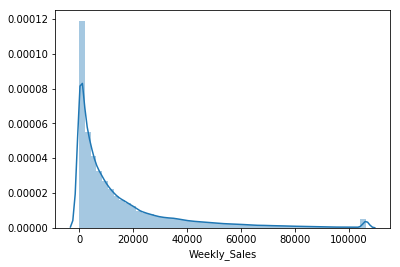

In [450]:
sns.distplot(df.Weekly_Sales)
plt.show()

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


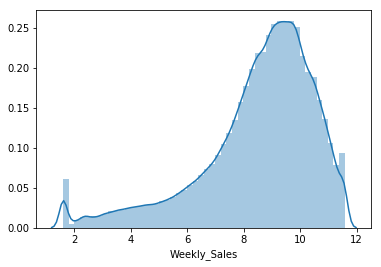

In [451]:
sns.distplot(np.log(df.Weekly_Sales))
plt.show()

For Regression, the target should follow normal distribution. Therefore, applied log transformation.

In [452]:
df.Weekly_Sales = np.log(df.Weekly_Sales)
df.rename(columns={'Weekly_Sales': 'log_Weekly_Sales'},inplace=True)

Replace the '.' in column names with '_'

In [454]:
df.columns = df.columns.str.replace(".", "_")

In [455]:
cat_vars = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['uint8']]
print(cat_vars)

['Store_2_0', 'Store_3_0', 'Store_4_0', 'Store_5_0', 'Store_6_0', 'Store_7_0', 'Store_8_0', 'Store_9_0', 'Store_10_0', 'Store_11_0', 'Store_12_0', 'Store_13_0', 'Store_14_0', 'Store_15_0', 'Store_16_0', 'Store_17_0', 'Store_18_0', 'Store_19_0', 'Store_20_0', 'Store_21_0', 'Store_22_0', 'Store_23_0', 'Store_24_0', 'Store_25_0', 'Store_26_0', 'Store_27_0', 'Store_28_0', 'Store_29_0', 'Store_30_0', 'Store_31_0', 'Store_32_0', 'Store_33_0', 'Store_34_0', 'Store_35_0', 'Store_36_0', 'Store_37_0', 'Store_38_0', 'Store_39_0', 'Store_40_0', 'Store_41_0', 'Store_42_0', 'Store_43_0', 'Store_44_0', 'Store_45_0', 'Dept_2_0', 'Dept_3_0', 'Dept_4_0', 'Dept_5_0', 'Dept_6_0', 'Dept_7_0', 'Dept_8_0', 'Dept_9_0', 'Dept_10_0', 'Dept_11_0', 'Dept_12_0', 'Dept_13_0', 'Dept_14_0', 'Dept_16_0', 'Dept_17_0', 'Dept_18_0', 'Dept_19_0', 'Dept_20_0', 'Dept_21_0', 'Dept_22_0', 'Dept_23_0', 'Dept_24_0', 'Dept_25_0', 'Dept_26_0', 'Dept_27_0', 'Dept_28_0', 'Dept_29_0', 'Dept_30_0', 'Dept_31_0', 'Dept_32_0', 'Dept_33_

In [456]:
num_vars = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['float32','float64','int32','int64']]
print(num_vars)

['Avg_WeeklySales_by_Store_Dept', 'CPI', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Max_WeeklySales_by_Store_Dept', 'Median_WeeklySales_by_Store_Dept', 'Min_WeeklySales_by_Store_Dept', 'Size', 'Std_WeeklySales_by_Store_Dept', 'Temperature', 'Unemployment', 'log_Weekly_Sales']


Correlation of df

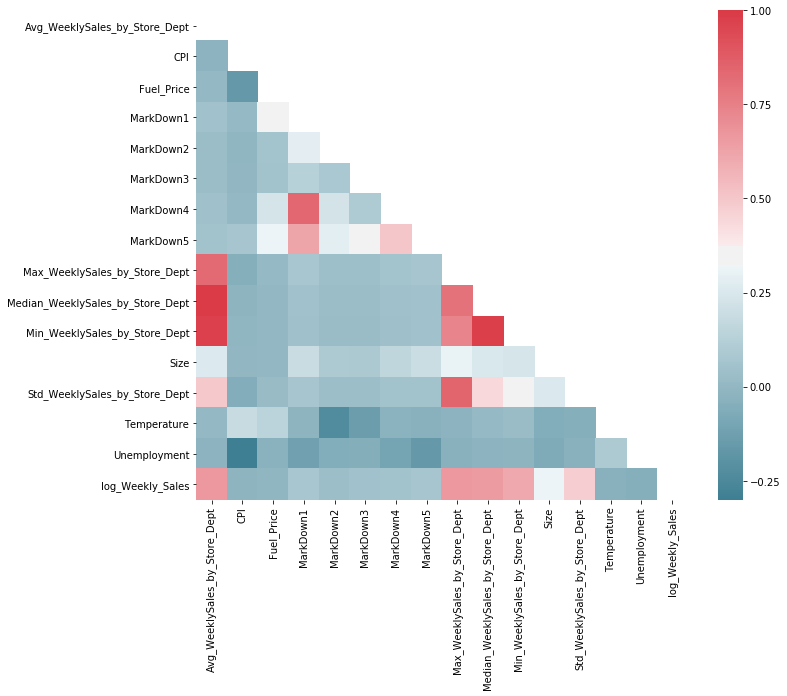

In [457]:
corr = df[num_vars].corr()


mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap)
plt.show()

In [458]:
corr_df = corr['log_Weekly_Sales']
corr_df.sort_values(ascending=False)

log_Weekly_Sales                    1.000000
Avg_WeeklySales_by_Store_Dept       0.665643
Max_WeeklySales_by_Store_Dept       0.665568
Median_WeeklySales_by_Store_Dept    0.655460
Min_WeeklySales_by_Store_Dept       0.607336
Std_WeeklySales_by_Store_Dept       0.478610
Size                                0.315027
MarkDown1                           0.070967
MarkDown5                           0.070161
MarkDown4                           0.059360
MarkDown3                           0.054588
MarkDown2                           0.031114
Fuel_Price                         -0.006057
CPI                                -0.015868
Temperature                        -0.039230
Unemployment                       -0.043133
Name: log_Weekly_Sales, dtype: float64

Selected the numerical variables having high correlation with y variable

In [459]:
list_Corr = ['Avg_WeeklySales_by_Store_Dept',
            'Max_WeeklySales_by_Store_Dept',
            'Median_WeeklySales_by_Store_Dept',
            'Min_WeeklySales_by_Store_Dept',
            'Std_WeeklySales_by_Store_Dept',
            'Size']

In [461]:
df_ANOVA = pd.DataFrame()
for col in cat_vars:
        groupList = []
        for item in df[col].unique():
            g = df.log_Weekly_Sales[df[col] == item]
            groupList.append(g) 
        F_value, p_value = stats.f_oneway(*groupList)
        df_ANOVA = df_ANOVA.append({'Feature': col,
                                   'F_value': round(F_value,3),
                                   'p_value': round(p_value,3)
                                   },ignore_index=True)
df_ANOVA = df_ANOVA.sort_values(by=['F_value'],ascending=False)  
df_ANOVA.head(20)

,F_value,Feature,p_value
124,24830.397,Type_C,0.0
94,24362.385,Dept_54_0,0.0
86,15543.203,Dept_45_0,0.0
99,13090.766,Dept_60_0,0.0
98,13022.536,Dept_59_0,0.0
92,11934.032,Dept_51_0,0.0
119,9596.163,Dept_95_0,0.0
79,9374.780,Dept_38_0,0.0
69,9136.881,Dept_28_0,0.0
116,9038.057,Dept_92_0,0.0


In [462]:
df_ANOVA[df_ANOVA.F_value > 1000].columns

Index(['F_value', 'Feature', 'p_value'], dtype='object')

Selected the categorical variables with high value of F_value

In [463]:
list_ANOVA = []
df1 = df_ANOVA[df_ANOVA['F_value'] > 1000]
for i in df1['Feature']:
    list_ANOVA.append(i)
# list_ANOVA

Created a new dataframe with variables selected from Correlation and ANOVA

In [464]:
df_new = pd.concat([df[list_Corr],df[list_ANOVA],df['log_Weekly_Sales']],axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 67 columns):
Avg_WeeklySales_by_Store_Dept       421570 non-null float64
Max_WeeklySales_by_Store_Dept       421570 non-null float64
Median_WeeklySales_by_Store_Dept    421570 non-null float64
Min_WeeklySales_by_Store_Dept       421570 non-null float64
Std_WeeklySales_by_Store_Dept       421570 non-null float64
Size                                421570 non-null float64
Type_C                              421570 non-null uint8
Dept_54_0                           421570 non-null uint8
Dept_45_0                           421570 non-null uint8
Dept_60_0                           421570 non-null uint8
Dept_59_0                           421570 non-null uint8
Dept_51_0                           421570 non-null uint8
Dept_95_0                           421570 non-null uint8
Dept_38_0                           421570 non-null uint8
Dept_28_0                           421570 non-null uint8
Dept_92

In [465]:
X = df_new[df_new.columns.difference(['log_Weekly_Sales'])]
y = df_new['log_Weekly_Sales']

### Feature Selection

In [466]:
X.columns

Index(['Avg_WeeklySales_by_Store_Dept', 'Dept_12_0', 'Dept_13_0', 'Dept_18_0',
       'Dept_19_0', 'Dept_23_0', 'Dept_27_0', 'Dept_28_0', 'Dept_2_0',
       'Dept_31_0', 'Dept_34_0', 'Dept_36_0', 'Dept_38_0', 'Dept_40_0',
       'Dept_41_0', 'Dept_45_0', 'Dept_46_0', 'Dept_47_0', 'Dept_48_0',
       'Dept_4_0', 'Dept_51_0', 'Dept_52_0', 'Dept_54_0', 'Dept_56_0',
       'Dept_59_0', 'Dept_60_0', 'Dept_72_0', 'Dept_78_0', 'Dept_79_0',
       'Dept_7_0', 'Dept_81_0', 'Dept_82_0', 'Dept_83_0', 'Dept_85_0',
       'Dept_8_0', 'Dept_90_0', 'Dept_91_0', 'Dept_92_0', 'Dept_93_0',
       'Dept_95_0', 'Dept_98_0', 'Max_WeeklySales_by_Store_Dept',
       'Median_WeeklySales_by_Store_Dept', 'Min_WeeklySales_by_Store_Dept',
       'Size', 'Std_WeeklySales_by_Store_Dept', 'Store_10_0', 'Store_13_0',
       'Store_14_0', 'Store_20_0', 'Store_27_0', 'Store_2_0', 'Store_30_0',
       'Store_33_0', 'Store_36_0', 'Store_37_0', 'Store_38_0', 'Store_3_0',
       'Store_42_0', 'Store_43_0', 'Store_44_0', 'S

#### SelectKBest

Select the top 15 variables using SelectKBest

In [468]:
skb = SelectKBest(f_regression,k=15)
skb = skb.fit(X,y)
skb_features = X.columns[skb.get_support()]
selected_features_from_selectKBest = X[skb_features]
selected_features_from_selectKBest.head()

,Avg_WeeklySales_by_Store_Dept,Dept_28_0,Dept_38_0,Dept_45_0,Dept_51_0,Dept_54_0,Dept_59_0,Dept_60_0,Dept_95_0,Max_WeeklySales_by_Store_Dept,Median_WeeklySales_by_Store_Dept,Min_WeeklySales_by_Store_Dept,Size,Std_WeeklySales_by_Store_Dept,Type_C
0,22513.322937,0,0,0,0,0,0,0,0,57592.12,18535.48,14537.37,151315.0,9854.349032,0
1,22513.322937,0,0,0,0,0,0,0,0,57592.12,18535.48,14537.37,151315.0,9854.349032,0
2,22513.322937,0,0,0,0,0,0,0,0,57592.12,18535.48,14537.37,151315.0,9854.349032,0
3,22513.322937,0,0,0,0,0,0,0,0,57592.12,18535.48,14537.37,151315.0,9854.349032,0
4,22513.322937,0,0,0,0,0,0,0,0,57592.12,18535.48,14537.37,151315.0,9854.349032,0


#### RFE

Selected top 15 variables using RFE

In [470]:
rfe = RFE(LinearRegression(), n_features_to_select=15)
rfe = rfe.fit(X,y)
rfe_features = X.columns[rfe.get_support()]
selected_features_from_RFE = X[rfe_features]
selected_features_from_RFE.head()

,Dept_28_0,Dept_45_0,Dept_47_0,Dept_51_0,Dept_54_0,Dept_59_0,Dept_60_0,Dept_78_0,Store_30_0,Store_37_0,Store_38_0,Store_42_0,Store_43_0,Store_44_0,Type_C
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### F-Regression

Selected top variales based on F-regression

In [472]:
F_value,p_value = f_regression(X,y)
f_tuple = [(x,y,round(z,3)) for x,y,z in itertools.zip_longest(X.columns,F_value,p_value)]
df_F = pd.DataFrame(f_tuple,columns=['feature','F_value','p_value']).sort_values(['F_value'],ascending=False)
df_F = df_F.sort_values(by=['F_value'],ascending=False)
# df_F = df_F[df_F['p_value'] < 0.05]
df_F = df_F.head(10)

In [473]:
F_Regression_columns = []
for i in df_F.feature:
    F_Regression_columns.append(i)

In [474]:
skb_columns = selected_features_from_selectKBest.columns
rfe_columns = selected_features_from_RFE.columns
F_Regression_columns = F_Regression_columns

In [475]:
selected_features = set([])
for x,y,z in itertools.zip_longest(skb_columns,rfe_columns,F_Regression_columns):
    if(x):
        selected_features.add(x) 
    if(y):
        selected_features.add(y)
    if(z):
        selected_features.add(z)

Following are the final selected variables

In [476]:
selected_features

{'Avg_WeeklySales_by_Store_Dept',
 'Dept_28_0',
 'Dept_38_0',
 'Dept_45_0',
 'Dept_47_0',
 'Dept_51_0',
 'Dept_54_0',
 'Dept_59_0',
 'Dept_60_0',
 'Dept_78_0',
 'Dept_95_0',
 'Max_WeeklySales_by_Store_Dept',
 'Median_WeeklySales_by_Store_Dept',
 'Min_WeeklySales_by_Store_Dept',
 'Size',
 'Std_WeeklySales_by_Store_Dept',
 'Store_30_0',
 'Store_37_0',
 'Store_38_0',
 'Store_42_0',
 'Store_43_0',
 'Store_44_0',
 'Type_C'}

#### VIF

Applied VIF to the sekected variables to remove any multi collinearity

In [478]:
formula = 'log_Weekly_Sales~' + '+'.join(selected_features)

In [479]:
formula

'log_Weekly_Sales~Dept_28_0+Std_WeeklySales_by_Store_Dept+Store_44_0+Dept_54_0+Dept_60_0+Dept_45_0+Dept_47_0+Min_WeeklySales_by_Store_Dept+Store_43_0+Avg_WeeklySales_by_Store_Dept+Dept_38_0+Store_42_0+Median_WeeklySales_by_Store_Dept+Dept_59_0+Store_30_0+Store_38_0+Dept_95_0+Store_37_0+Size+Dept_51_0+Type_C+Dept_78_0+Max_WeeklySales_by_Store_Dept'

In [502]:
formula = 'log_Weekly_Sales~Dept_28_0+Std_WeeklySales_by_Store_Dept+Store_44_0+Dept_54_0+Dept_60_0+Dept_45_0+Dept_47_0+Store_43_0+Dept_38_0+Median_WeeklySales_by_Store_Dept+Dept_59_0+Store_30_0+Store_38_0+Dept_95_0+Store_37_0+Size+Dept_51_0+Dept_78_0'

In [503]:
a,b = dmatrices(data=df_new,formula_like=formula,return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(b.values,i) for i in range(b.shape[1])]
vif['feature'] = b.columns

In [504]:
vif.shape

(19, 2)

In [505]:
vif.sort_values(by=['VIF'],ascending=False)

,VIF,feature
0,8.771079,Intercept
10,1.603006,Median_WeeklySales_by_Store_Dept
16,1.422866,Size
2,1.318708,Std_WeeklySales_by_Store_Dept
14,1.143214,Dept_95_0
9,1.115516,Dept_38_0
15,1.070641,Store_37_0
13,1.070490,Store_38_0
3,1.069020,Store_44_0
12,1.065784,Store_30_0


In [506]:
final_features = []
for i in vif.feature:
    if(i != 'Intercept'):
        final_features.append(i)

These are the final features selected based on VIF

In [507]:
final_features

['Dept_28_0',
 'Std_WeeklySales_by_Store_Dept',
 'Store_44_0',
 'Dept_54_0',
 'Dept_60_0',
 'Dept_45_0',
 'Dept_47_0',
 'Store_43_0',
 'Dept_38_0',
 'Median_WeeklySales_by_Store_Dept',
 'Dept_59_0',
 'Store_30_0',
 'Store_38_0',
 'Dept_95_0',
 'Store_37_0',
 'Size',
 'Dept_51_0',
 'Dept_78_0']

Created a new dataframe using selected variables

In [515]:
df_final = df_new[final_features + ['log_Weekly_Sales']]
df_final.head()

,Dept_28_0,Std_WeeklySales_by_Store_Dept,Store_44_0,Dept_54_0,Dept_60_0,Dept_45_0,Dept_47_0,Store_43_0,Dept_38_0,Median_WeeklySales_by_Store_Dept,Dept_59_0,Store_30_0,Store_38_0,Dept_95_0,Store_37_0,Size,Dept_51_0,Dept_78_0,log_Weekly_Sales
0,0,9854.349032,0,0,0,0,0,0,0,18535.48,0,0,0,0,0,151315.0,0,0,10.123607
1,0,9854.349032,0,0,0,0,0,0,0,18535.48,0,0,0,0,0,151315.0,0,0,10.737255
2,0,9854.349032,0,0,0,0,0,0,0,18535.48,0,0,0,0,0,151315.0,0,0,10.635748
3,0,9854.349032,0,0,0,0,0,0,0,18535.48,0,0,0,0,0,151315.0,0,0,9.873211
4,0,9854.349032,0,0,0,0,0,0,0,18535.48,0,0,0,0,0,151315.0,0,0,9.990944


In [516]:
num_final_vars = [key for key in dict(df_final.dtypes) if df_final.dtypes[key] in ['float64']]
num_final_vars

['Std_WeeklySales_by_Store_Dept',
 'Median_WeeklySales_by_Store_Dept',
 'Size',
 'log_Weekly_Sales']

In [521]:
def TransformVariables(x):
    print("Variable: {}".format(x))
    print("Correlation without transformation: {}".format(np.corrcoef((df_final[x]),df_final['log_Weekly_Sales'])[0][1]))
    print("Correlation for log transformation: {}".format(np.corrcoef(np.log(df_final[x] + 1),df_final['log_Weekly_Sales'])[0][1]))
    print("Correlation for exp transformation: {}".format(np.corrcoef(np.exp(df_final[x]),df_final['log_Weekly_Sales'])[0][1]))
    print("Correlation for square transformation: {}".format(np.corrcoef(np.square(df_final[x]),df_final['log_Weekly_Sales'])[0][1]))
    print("Correlation for squareroot transformation: {}".format(np.corrcoef(np.sqrt(df_final[x]),df_final['log_Weekly_Sales'])[0][1]))
    print("") 

In [522]:
for var in num_final_vars:
    if(var != 'log_Weekly_Sales'):
        TransformVariables(var)    

Variable: Std_WeeklySales_by_Store_Dept
Correlation without transformation: 0.47861029744130607
Correlation for log transformation: 0.7564303672415315
Correlation for exp transformation: nan
Correlation for square transformation: 0.2855320605176691
Correlation for squareroot transformation: 0.6393300489454792

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3103: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]




Variable: Median_WeeklySales_by_Store_Dept
Correlation without transformation: 0.6554598644235555
Correlation for log transformation: 0.9507505707914564
Correlation for exp transformation: nan
Correlation for square transformation: 0.4463500412939067
Correlation for squareroot transformation: 0.8236819243666199

Variable: Size
Correlation without transformation: 0.3150266485548697
Correlation for log transformation: 0.3263951978331143
Correlation for exp transformation: nan
Correlation for square transformation: 0.2932341655524892
Correlation for squareroot transformation: 0.32281233694801853



Applied log transformation on these variables to obtain more correlation with the y variable

In [523]:
df_final['log_Std_WeeklySales_by_Store_Dept'] = df_final['Std_WeeklySales_by_Store_Dept'].apply(lambda x: np.log(x + 1))
df_final['log_Median_WeeklySales_by_Store_Dept'] = df_final['Median_WeeklySales_by_Store_Dept'].apply(lambda x: np.log(x + 1))

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [524]:
df_final.drop(columns=['Std_WeeklySales_by_Store_Dept','Median_WeeklySales_by_Store_Dept'], inplace=True)

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [525]:
df_final.head()

,Dept_28_0,Store_44_0,Dept_54_0,Dept_60_0,Dept_45_0,Dept_47_0,Store_43_0,Dept_38_0,Dept_59_0,Store_30_0,Store_38_0,Dept_95_0,Store_37_0,Size,Dept_51_0,Dept_78_0,log_Weekly_Sales,log_Std_WeeklySales_by_Store_Dept,log_Median_WeeklySales_by_Store_Dept
0,0,0,0,0,0,0,0,0,0,0,0,0,0,151315.0,0,0,10.123607,9.19577,9.827496
1,0,0,0,0,0,0,0,0,0,0,0,0,0,151315.0,0,0,10.737255,9.19577,9.827496
2,0,0,0,0,0,0,0,0,0,0,0,0,0,151315.0,0,0,10.635748,9.19577,9.827496
3,0,0,0,0,0,0,0,0,0,0,0,0,0,151315.0,0,0,9.873211,9.19577,9.827496
4,0,0,0,0,0,0,0,0,0,0,0,0,0,151315.0,0,0,9.990944,9.19577,9.827496


### Modelling

In [529]:
train,test = train_test_split(df_final,test_size=0.3,random_state=123)

In [530]:
train_X = train[train.columns.difference(['log_Weekly_Sales'])]
test_X = test[test.columns.difference(['log_Weekly_Sales'])]
train_y = train['log_Weekly_Sales']
test_y = test['log_Weekly_Sales']

#### 1. Linear Regression

In [531]:
formula = 'log_Weekly_Sales~' + '+'.join(train_X.columns)
formula

'log_Weekly_Sales~Dept_28_0+Dept_38_0+Dept_45_0+Dept_47_0+Dept_51_0+Dept_54_0+Dept_59_0+Dept_60_0+Dept_78_0+Dept_95_0+Size+Store_30_0+Store_37_0+Store_38_0+Store_43_0+Store_44_0+log_Median_WeeklySales_by_Store_Dept+log_Std_WeeklySales_by_Store_Dept'

In [560]:
formula = 'log_Weekly_Sales~Dept_45_0+Dept_47_0+Dept_51_0+Dept_54_0+Dept_59_0+Dept_95_0+Size+Store_30_0+Store_43_0+log_Median_WeeklySales_by_Store_Dept+log_Std_WeeklySales_by_Store_Dept'

In [627]:
model = sm.ols(formula,data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       log_Weekly_Sales   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 2.553e+05
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:32:20   Log-Likelihood:            -2.8245e+05
No. Observations:              295099   AIC:                         5.649e+05
Df Residuals:                  295087   BIC:                         5.651e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [639]:
train['pred'] = pd.DataFrame((model.predict(train)))
test['pred'] = pd.DataFrame((model.predict(test)))

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [633]:
Corr_train = stats.stats.pearsonr(train.log_Weekly_Sales , train.pred)
print("CORR for train data is {}.".format(Corr_train[0]))
Corr_test = stats.stats.pearsonr(test.log_Weekly_Sales , test.pred)
print("CORR for test data is {}.".format(Corr_test[0]))

CORR for train data is 0.9512748744809334.
CORR for test data is 0.9498364325297801.


In [634]:
error_train = np.sqrt(metrics.mean_squared_error(train_y,  train.pred))
print("The RMSE for train data is {}.".format(error_train))
error_test = np.sqrt(metrics.mean_squared_error(test_y,  test.pred))
print("The RMSE for test data is {}.".format(error_test))

error_train = (metrics.mean_absolute_error(train_y,  train.pred))
print("The MAPE for train data is {}.".format(error_train))
error_test = (metrics.mean_absolute_error(test_y,  test.pred))
print("The MAPE for test data is {}.".format(error_test))

print("The R-squared value fo train is {}.".format(metrics.r2_score(train_y, train.pred)))
print("The R-squared value fo test is {}.".format(metrics.r2_score(test_y, test.pred)))

The RMSE for train data is 0.6301518143129069.
The RMSE for test data is 0.640934542810289.
The MAPE for train data is 0.30012892011758224.
The MAPE for test data is 0.30257592385135684.
The R-squared value fo train is 0.9049238868187157.
The R-squared value fo test is 0.9021872058878285.


In [632]:
print("The RMSPE for train data is {}.".format(rmse(train_y, train.pred)))
print("The RMSPE for test data is {}.".format(rmse(test_y, test.pred)))

The RMSPE for train data is 0.25374608337010174.
The RMSPE for test data is 0.2643652866026853.


In [574]:
#Decile analysis - Train

train['Deciles']=pd.qcut(train['pred'],10, labels=False)

avg_actual = train[['Deciles','log_Weekly_Sales']].groupby(train.Deciles).mean().sort_index(ascending=False)['log_Weekly_Sales']
avg_pred = train[['Deciles','pred']].groupby(train.Deciles).mean().sort_index(ascending=False)['pred']

Decile_analysis_train = pd.concat([avg_actual, avg_pred], axis=1)

Decile_analysis_train

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,log_Weekly_Sales,pred
Deciles,,
9,11.030208,11.048746
8,10.347194,10.338716
7,9.869252,9.856663
6,9.493145,9.470496
5,9.075908,9.090062
4,8.685664,8.677075
3,8.201377,8.200206
2,7.596930,7.597155
1,6.612315,6.618405


In [575]:
#Decile analysis - Train
test['Deciles']=pd.qcut(test['pred'],10, labels=False)

avg_actual_test = test[['Deciles','log_Weekly_Sales']].groupby(test.Deciles).mean().sort_index(ascending=False)['log_Weekly_Sales']
avg_pred_test = test[['Deciles','pred']].groupby(test.Deciles).mean().sort_index(ascending=False)['pred']

Decile_analysis_test = pd.concat([avg_actual_test, avg_pred_test], axis=1)

Decile_analysis_test

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,log_Weekly_Sales,pred
Deciles,,
9,11.031629,11.048489
8,10.344647,10.333573
7,9.866956,9.853975
6,9.482701,9.474904
5,9.080437,9.089468
4,8.677477,8.676470
3,8.203224,8.198245
2,7.597842,7.596184
1,6.595663,6.611129


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

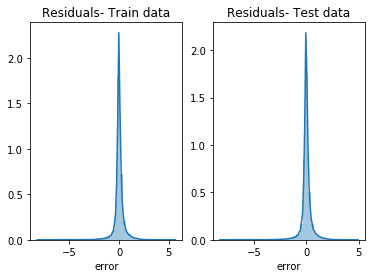

In [640]:
train['error'] = train['log_Weekly_Sales'] - train['pred']
plt.subplot(1,2,1)
sns.distplot(train['error'])
plt.title('Residuals- Train data')

test['error'] = test['log_Weekly_Sales'] - test['pred']
plt.subplot(1,2,2)
sns.distplot(test['error'])
plt.title('Residuals- Test data')

plt.show()

The residuals are following normal distribution as expected

#### 2. Random Forest

In [577]:
rf = RandomForestRegressor()
rf.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [579]:
pred = rf.predict(train_X)

In [582]:
np.sqrt(mean_squared_error(train_y, pred))

0.6048907781728429

Text(0,0.5,'RMSE')

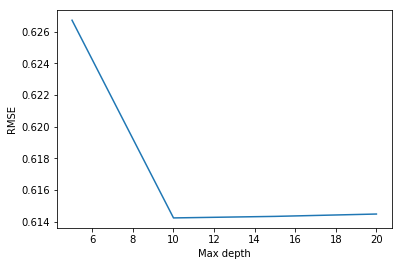

In [588]:
max_depth_range = [5,10,15,20]
RMSE_Scores = []

for i in max_depth_range:
    rf = RandomForestRegressor(max_depth=i,random_state=123)
    MSE = cross_val_score(rf, train_X, train_y, cv=5, scoring='neg_mean_squared_error')
    RMSE_Scores.append(np.mean(np.sqrt(-MSE)))

plt.plot(max_depth_range,RMSE_Scores)
plt.xlabel('Max depth')
plt.ylabel('RMSE')

Text(0,0.5,'RMSE')

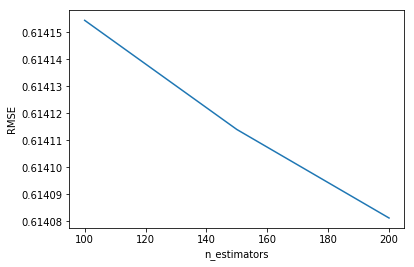

In [589]:
n_estimators = [100,150,200]
RMSE_Scores = []

for i in n_estimators:
    rf = RandomForestRegressor(n_estimators=i,random_state=123)
    MSE = cross_val_score(rf, train_X, train_y, cv=5, scoring='neg_mean_squared_error')
    RMSE_Scores.append(np.mean(np.sqrt(-MSE)))

plt.plot(n_estimators,RMSE_Scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

Text(0,0.5,'RMSE')

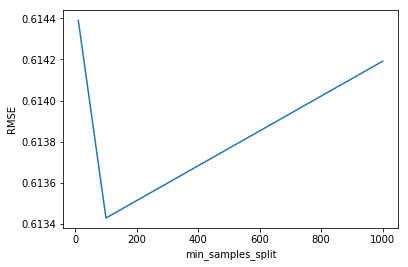

In [591]:
min_samples_split = [10,100,1000]
RMSE_Scores = []

for i in min_samples_split:
    rf = RandomForestRegressor(min_samples_split=i,random_state=123)
    MSE = cross_val_score(rf, train_X, train_y, cv=5, scoring='neg_mean_squared_error')
    RMSE_Scores.append(np.mean(np.sqrt(-MSE)))

plt.plot(min_samples_split,RMSE_Scores)
plt.xlabel('min_samples_split')
plt.ylabel('RMSE')

Build a GridSearchCV to obtain the best model

In [595]:
parameters = {'n_estimators': [100],
               'max_depth': [10,12,15],
               'min_samples_split': [10,100,200]}

In [596]:
gscv_rf = GridSearchCV(RandomForestRegressor(),
                       param_grid=parameters,
                       cv=5)
gscv_rf.fit(train_X,train_y)
print("")

In [598]:
gscv_rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=100,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [599]:
print("Best Hyperparameters::\n{}".format(gscv_rf.best_params_))

Best Hyperparameters::
{'max_depth': 12, 'min_samples_split': 100, 'n_estimators': 100}


In [600]:
print("The R-squared value fo train is {}.".format(metrics.r2_score(train_y, gscv_rf.predict(train_X))))
print("The R-squared value fo test is {}.".format(metrics.r2_score(test_y, gscv_rf.predict(test_X))))

The R-squared value fo train is 0.9123647246898783.
The R-squared value fo test is 0.9080444785604187.


In [601]:
error_train = np.sqrt(metrics.mean_squared_error(train_y, gscv_rf.predict(train_X)))
print("The RMSE for train data is {}.".format(error_train))
error_test = np.sqrt(metrics.mean_squared_error(test_y, gscv_rf.predict(test_X)))
print("The RMSE for test data is {}.".format(error_test))

error_train = (metrics.mean_absolute_error(train_y, gscv_rf.predict(train_X)))
print("The MAPE for train data is {}.".format(error_train))
error_test = (metrics.mean_absolute_error(test_y, gscv_rf.predict(test_X)))
print("The MAPE for test data is {}.".format(error_test))

The RMSE for train data is 0.6049910629225628.
The RMSE for test data is 0.6214479381351319.
The MAPE for train data is 0.3086136321517922.
The MAPE for test data is 0.31321023798968517.


In [602]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [603]:
print("The RMSPE for train data is {}.".format(rmse(train_y, gscv_rf.predict(train_X))))
print("The RMSPE for test data is {}.".format(rmse(test_y, gscv_rf.predict(test_X))))

The RMSPE for train data is 0.22444168429132136.
The RMSPE for test data is 0.23693998463462088.


In [635]:
train['pred'] = gscv_rf.predict(train_X)
test['pred'] = gscv_rf.predict(test_X)

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [636]:
Corr_train = stats.stats.pearsonr(train.log_Weekly_Sales , train.pred)
print("CORR for train data is {}.".format(Corr_train[0]))
Corr_test = stats.stats.pearsonr(test.log_Weekly_Sales , test.pred)
print("CORR for test data is {}.".format(Corr_test[0]))

CORR for train data is 0.9551778587879581.
CORR for test data is 0.9529138258684715.


In [605]:
Decile_analysis_test = pd.DataFrame()
test['Decile'] = pd.qcut(test['pred'],8,labels=False)

avg_actual = test[['Decile','log_Weekly_Sales']].groupby(['Decile']).mean().sort_index(ascending=False)['log_Weekly_Sales']
avg_pred = test[['Decile','pred']].groupby(['Decile']).mean().sort_index(ascending=False)['pred']

Decile_analysis_test = pd.concat([avg_actual,avg_pred],axis=1)
Decile_analysis_test

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,log_Weekly_Sales,pred
Decile,,
7,10.934360,10.932319
6,10.153241,10.153239
5,9.648158,9.649008
4,9.156307,9.152392
3,8.606914,8.614141
2,7.980515,7.987035
1,7.012573,7.015233
0,4.532691,4.528491


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

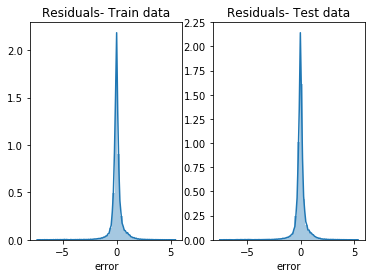

In [622]:
train['error'] = train['log_Weekly_Sales'] - train['pred']
plt.subplot(1,2,1)
sns.distplot(train['error'])
plt.title('Residuals- Train data')

test['error'] = test['log_Weekly_Sales'] - test['pred']
plt.subplot(1,2,2)
sns.distplot(test['error'])
plt.title('Residuals- Test data')

plt.show()

Residuals are following normal distribution as expected

#### 3. Gradient Boosting

In [607]:
model = GradientBoostingRegressor()
model.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [608]:
pred = model.predict(train_X)
np.sqrt(mean_squared_error(train_y, pred))

0.6181498684572411

Text(0,0.5,'RMSE')

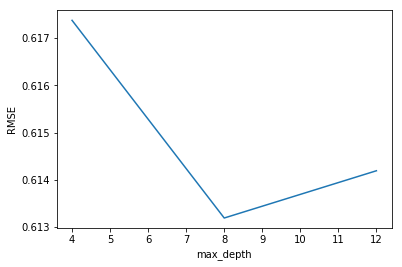

In [609]:
max_depth = [4,8,12]
RMSE_Scores = []

for i in max_depth:
    gb = GradientBoostingRegressor(max_depth=i,random_state=123)
    MSE = cross_val_score(gb, train_X, train_y, cv=5, scoring='neg_mean_squared_error')
    RMSE_Scores.append(np.mean(np.sqrt(-MSE)))

plt.plot(max_depth,RMSE_Scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

Build a GridSearchCV to obatin the best model

In [612]:
parameters = {'n_estimators': [100,1000],
               'max_depth': [8]
               }

In [613]:
gscv_gb = GridSearchCV(GradientBoostingRegressor(),
                       param_grid=parameters,
                       cv=5)
gscv_gb.fit(train_X,train_y)
print("")

In [615]:
print("Best Hyperparameters::\n{}".format(gscv_gb.best_params_))

Best Hyperparameters::
{'max_depth': 8, 'n_estimators': 100}


In [616]:
print("The R-squared value fo train is {}.".format(metrics.r2_score(train_y, gscv_gb.predict(train_X))))
print("The R-squared value fo test is {}.".format(metrics.r2_score(test_y, gscv_gb.predict(test_X))))

The R-squared value fo train is 0.9123731223457284.
The R-squared value fo test is 0.9079981200329587.


In [617]:
error_train = np.sqrt(metrics.mean_squared_error(train_y, gscv_gb.predict(train_X)))
print("The RMSE for train data is {}.".format(error_train))
error_test = np.sqrt(metrics.mean_squared_error(test_y, gscv_gb.predict(test_X)))
print("The RMSE for test data is {}.".format(error_test))

error_train = (metrics.mean_absolute_error(train_y, gscv_gb.predict(train_X)))
print("The MAPE for train data is {}.".format(error_train))
error_test = (metrics.mean_absolute_error(test_y, gscv_gb.predict(test_X)))
print("The MAPE for test data is {}.".format(error_test))

The RMSE for train data is 0.6049620755745075.
The RMSE for test data is 0.6216045670181469.
The MAPE for train data is 0.307980815754901.
The MAPE for test data is 0.3124867099723736.


In [618]:
print("The RMSPE for train data is {}.".format(rmse(train_y, gscv_gb.predict(train_X))))
print("The RMSPE for test data is {}.".format(rmse(test_y, gscv_gb.predict(test_X))))

The RMSPE for train data is 0.22499873954515856.
The RMSPE for test data is 0.2377309661395887.


In [637]:
train['pred'] = gscv_gb.predict(train_X)
test['pred'] = gscv_gb.predict(test_X)

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [638]:
Corr_train = stats.stats.pearsonr(train.log_Weekly_Sales , train.pred)
print("CORR for train data is {}.".format(Corr_train[0]))
Corr_test = stats.stats.pearsonr(test.log_Weekly_Sales , test.pred)
print("CORR for test data is {}.".format(Corr_test[0]))

CORR for train data is 0.9551823993765569.
CORR for test data is 0.9528897569907158.


In [624]:
Decile_analysis_test = pd.DataFrame()
test['Decile'] = pd.qcut(test['pred'],8,labels=False)

avg_actual = test[['Decile','log_Weekly_Sales']].groupby(['Decile']).mean().sort_index(ascending=False)['log_Weekly_Sales']
avg_pred = test[['Decile','pred']].groupby(['Decile']).mean().sort_index(ascending=False)['pred']

Decile_analysis_test = pd.concat([avg_actual,avg_pred],axis=1)
Decile_analysis_test

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,log_Weekly_Sales,pred
Decile,,
7,10.934748,10.931974
6,10.153527,10.152767
5,9.646690,9.647615
4,9.158234,9.152649
3,8.607979,8.614566
2,7.978769,7.986702
1,7.013361,7.017387
0,4.533330,4.531575


C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

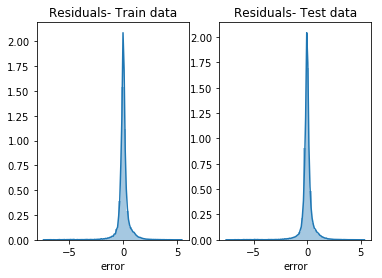

In [625]:
train['error'] = train['log_Weekly_Sales'] - train['pred']
plt.subplot(1,2,1)
sns.distplot(train['error'])
plt.title('Residuals- Train data')

test['error'] = test['log_Weekly_Sales'] - test['pred']
plt.subplot(1,2,2)
sns.distplot(test['error'])
plt.title('Residuals- Test data')

plt.show()

Residuals are following normal distribution as expected

### Forecasting for new data

In [715]:
test = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\2. Walmart Store Sales Forecasting\\data\\test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [716]:
sales = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\2. Walmart Store Sales Forecasting\\data\\stores.csv')
sales.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [717]:
features = pd.read_csv('C:\\Analytix\\Git\\Analytix\\Projects\\2. Walmart Store Sales Forecasting\\data\\features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [718]:
new_data = features.merge(how='inner',on='Store',right=sales)
new_data = test.merge(on=['Store','Date'],right=new_data, how='left')
new_data.head()

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,False,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,True,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,False,A,151315


In [719]:
new_data.Date = pd.to_datetime(new_data.Date)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 16 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
Date            115064 non-null datetime64[ns]
IsHoliday_x     115064 non-null bool
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       114915 non-null float64
MarkDown2       86437 non-null float64
MarkDown3       105235 non-null float64
MarkDown4       102176 non-null float64
MarkDown5       115064 non-null float64
CPI             76902 non-null float64
Unemployment    76902 non-null float64
IsHoliday_y     115064 non-null bool
Type            115064 non-null object
Size            115064 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 13.4+ MB


In [720]:
new_data.drop(columns=['IsHoliday_y'], inplace=True)

In [721]:
def MissingTreatment(x):
    x = x.fillna(0)
    return x
new_data = new_data.apply(lambda x: MissingTreatment(x))
new_data.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
Date            115064 non-null datetime64[ns]
IsHoliday_x     115064 non-null bool
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       115064 non-null float64
MarkDown2       115064 non-null float64
MarkDown3       115064 non-null float64
MarkDown4       115064 non-null float64
MarkDown5       115064 non-null float64
CPI             115064 non-null float64
Unemployment    115064 non-null float64
Type            115064 non-null object
Size            115064 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 13.3+ MB


In [ ]:
numeric_vars = [key for key in dict(new_data.dtypes) if dict(new_data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
numeric_vars.remove('Store')
numeric_vars.remove('Dept')
print(numeric_vars)

In [723]:
for var in numeric_vars:
    new_data[var] = new_data[var].clip_upper(data[var].quantile(0.99))
    new_data[var] = new_data[var].clip_lower(data[var].quantile(0.01))

In [724]:
new_data 

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1.0,1.0,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315.0
1,1.0,1.0,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315.0
2,1.0,1.0,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315.0
3,1.0,1.0,2012-11-23,True,56.23,3.211,883.59,4.17,2083.28,209.91,303.32,223.561947,6.573,A,151315.0
4,1.0,1.0,2012-11-30,False,52.34,3.207,2460.03,0.00,2083.28,150.57,6966.34,223.610984,6.573,A,151315.0
5,1.0,1.0,2012-12-07,False,64.12,3.198,6343.16,0.00,270.00,2928.90,10147.90,223.660021,6.573,A,151315.0
6,1.0,1.0,2012-12-14,False,48.89,3.168,3504.83,0.00,73.26,1636.80,2779.60,223.719277,6.573,A,151315.0
7,1.0,1.0,2012-12-21,False,56.02,3.098,8231.71,0.00,274.00,358.15,2834.02,223.839845,6.573,A,151315.0
8,1.0,1.0,2012-12-28,True,44.79,3.108,12659.55,21813.16,174.78,74.46,1208.86,223.960414,6.573,A,151315.0
9,1.0,1.0,2013-01-04,False,41.73,3.161,1214.08,21813.16,15.01,72.36,3940.02,224.080983,6.525,A,151315.0


In [808]:
store = []
dept = []
std = []
med = []
for i in range(1,46):
    for j in range(1,99):
        store.append(i)
        dept.append(j)
        std.append(data.loc[(data.Store == i) & (data.Dept == j)]['Std_WeeklySales_by_Store_Dept'].mean())
        med.append(data.loc[(data.Store == i) & (data.Dept == j)]['Median_WeeklySales_by_Store_Dept'].mean())
store_data = pd.DataFrame([store,dept,std,med])               

In [818]:
store_data = store_data.T
store_data.head()

,0,1,2,3
0,1.0,1.0,9854.349032,18535.48
1,1.0,2.0,3440.673222,45561.85
2,1.0,3.0,8708.978853,10366.85
3,1.0,4.0,2930.698313,36579.96
4,1.0,5.0,11330.286495,21183.42


In [838]:
def FeatureEngineering(store,dept,var):
    if var == 'std':
        return store_data[(store_data[0] == store) & (store_data[1] == dept)][2].iloc[0]         
    elif var == 'median':
        return store_data[(store_data[0] == store) & (store_data[1] == dept)][3].iloc[0]
    else:
        return -1

Get the values from the training data

In [840]:
new_data['Std_WeeklySales_by_Store_Dept'] = new_data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'std'), axis=1)
new_data['Median_WeeklySales_by_Store_Dept'] = new_data.apply(lambda x: FeatureEngineering(x.Store,x.Dept,'median'), axis=1)

In [841]:
new_data.head()

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Std_WeeklySales_by_Store_Dept,Median_WeeklySales_by_Store_Dept
0,1.0,1.0,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315.0,9854.349032,18535.48
1,1.0,1.0,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315.0,9854.349032,18535.48
2,1.0,1.0,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315.0,9854.349032,18535.48
3,1.0,1.0,2012-11-23,True,56.23,3.211,883.59,4.17,2083.28,209.91,303.32,223.561947,6.573,A,151315.0,9854.349032,18535.48
4,1.0,1.0,2012-11-30,False,52.34,3.207,2460.03,0.00,2083.28,150.57,6966.34,223.610984,6.573,A,151315.0,9854.349032,18535.48


In [842]:
new_data['log_Std_WeeklySales_by_Store_Dept'] = new_data['Std_WeeklySales_by_Store_Dept'].apply(lambda x: np.log(x + 1))
new_data['log_Median_WeeklySales_by_Store_Dept'] = new_data['Median_WeeklySales_by_Store_Dept'].apply(lambda x: np.log(x + 1))

In [844]:
new_data_cat = new_data[['Store','Dept']]
for feature in ['Store','Dept']:
    new_data_cat = createDummyVariables(new_data_cat,feature)
new_data_cat.columns = new_data_cat.columns.str.replace(".", "_")
new_data_cat.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 123 columns):
Store_2_0     115064 non-null uint8
Store_3_0     115064 non-null uint8
Store_4_0     115064 non-null uint8
Store_5_0     115064 non-null uint8
Store_6_0     115064 non-null uint8
Store_7_0     115064 non-null uint8
Store_8_0     115064 non-null uint8
Store_9_0     115064 non-null uint8
Store_10_0    115064 non-null uint8
Store_11_0    115064 non-null uint8
Store_12_0    115064 non-null uint8
Store_13_0    115064 non-null uint8
Store_14_0    115064 non-null uint8
Store_15_0    115064 non-null uint8
Store_16_0    115064 non-null uint8
Store_17_0    115064 non-null uint8
Store_18_0    115064 non-null uint8
Store_19_0    115064 non-null uint8
Store_20_0    115064 non-null uint8
Store_21_0    115064 non-null uint8
Store_22_0    115064 non-null uint8
Store_23_0    115064 non-null uint8
Store_24_0    115064 non-null uint8
Store_25_0    115064 non-null uint8
Store_26_0    115064 non

In [846]:
df_new_data = pd.concat([new_data,new_data_cat],axis=1)
df_new_data.head()

,Store,Dept,Date,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Dept_87_0,Dept_90_0,Dept_91_0,Dept_92_0,Dept_93_0,Dept_94_0,Dept_95_0,Dept_96_0,Dept_97_0,Dept_98_0
0,1.0,1.0,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,2012-11-23,True,56.23,3.211,883.59,4.17,2083.28,209.91,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,2012-11-30,False,52.34,3.207,2460.03,0.00,2083.28,150.57,...,0,0,0,0,0,0,0,0,0,0


In [899]:
features = ['Dept_28_0',
             'log_Std_WeeklySales_by_Store_Dept',
             'Store_44_0',
             'Dept_54_0',
             'Dept_60_0',
             'Dept_45_0',
             'Dept_47_0',
             'Store_43_0',
             'Dept_38_0',
             'log_Median_WeeklySales_by_Store_Dept',
             'Dept_59_0',
             'Store_30_0',
             'Store_38_0',
             'Dept_95_0',
             'Store_37_0',
             'Size',
             'Dept_51_0',
             'Dept_78_0'
           ]

In [900]:
df_final = df_new_data[features]
df_final.head()

,Dept_28_0,log_Std_WeeklySales_by_Store_Dept,Store_44_0,Dept_54_0,Dept_60_0,Dept_45_0,Dept_47_0,Store_43_0,Dept_38_0,log_Median_WeeklySales_by_Store_Dept,Dept_59_0,Store_30_0,Store_38_0,Dept_95_0,Store_37_0,Size,Dept_51_0,Dept_78_0
0,0,9.19577,0,0,0,0,0,0,0,9.827496,0,0,0,0,0,151315.0,0,0
1,0,9.19577,0,0,0,0,0,0,0,9.827496,0,0,0,0,0,151315.0,0,0
2,0,9.19577,0,0,0,0,0,0,0,9.827496,0,0,0,0,0,151315.0,0,0
3,0,9.19577,0,0,0,0,0,0,0,9.827496,0,0,0,0,0,151315.0,0,0
4,0,9.19577,0,0,0,0,0,0,0,9.827496,0,0,0,0,0,151315.0,0,0


In [901]:
df_final.log_Median_WeeklySales_by_Store_Dept.fillna(df_final.log_Median_WeeklySales_by_Store_Dept.median(), inplace=True)
df_final.log_Std_WeeklySales_by_Store_Dept.fillna(df_final.log_Std_WeeklySales_by_Store_Dept.median(), inplace=True)

C:\Users\arundev.satheesan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Use the best Randm Forest model to predict the sales

In [918]:
solution = gscv_rf.predict(df_final)
solution = np.exp(solution)

Final Solution

In [919]:
sol_df = pd.concat([df_new_data.Date,pd.Series(solution)],axis=1)
sol_df.to_csv('solution.csv')